
# First-Order Approximations of LI Neurons

Until access to neuromorphic hardware becomes more widespread, most neuromorphic algorithms are simulated on "standard" hardware and then ported to neuromorphic hardware. There are plenty of frameworks that can do this. However, it can be instructive to build our own.

We're going to start by implementing a simulation of the leaky integrate-and-fire (LIF) neurons described in the previous page. We will implement our code in Python.

Recall from [last time](03%20-%20Basic%20Neuron%20Models.md) that we have the formula {eq}`eq:dvdt` describing the potential of a neuron as:

$$
v'(t) = \frac{1}{\tau}I(t) - \frac{1}{\tau}v(t)
$$

Because we are going to introduce other time constants, we will rename $\tau$ to be $\tau_{rc}$:

$$
v'(t) = \frac{1}{\tau_{rc}}I(t) - \frac{1}{\tau_{rc}}v(t)
$$ (eq:vprime)


(ssec:discrete-time-lif)=
## Simulating Neurons in Discrete Time

So far, we have a definition of how $v(t)$ changes over time ($v'(t)$) but we haven't actually defined $v(t)$ itself. We are going to *estimate* $v(t)$ using **discrete time**, meaning we'll split time into small time steps (like 0.001 seconds). We will refer to the amount of time that a step represents as $T_{step}$.

Then, rather than representing a precise time, $t$ instead represents the step number and is a positive integer ($t \in \mathbb{N}$). We will use square brackets to indicate that we are modeling in discrete time: $v[t]$.

If our neuron starts at $v_{init}$, then we can calculate our neuron's potential as:

$$
\begin{align}
v[0] &= v_{init} \\
v[t] &= v[t-1] (1 - \frac{T_{step}}{\tau_{rc}}) + \frac{T_{step}}{\tau_{rc}}I[t]
\end{align}
$$(eq:vdiscrete)

:::{dropdown} How did we get this value for $v[t]$?

We started with a definition of how $v(t)$ changes over time {eq}`eq:vprime` ($v'(t)$) but we did not actually define $v(t)$. As a first step of doing this, let's *approximate* its value using [Euler's method](https://en.wikipedia.org/wiki/Euler_method). Euler's method estimates a function by using its rate of change (in our case, $v'(t)$) and starting value.

## Euler's Approximation

If we already know $v(t)$ and the rate of change $v'(t)$ then for some small time increment $\Delta{}t$, we can estimate the value of $v(t+\Delta{}t)$ as:

$$
v(t + \Delta{}t) \approx v(t) + v'(t)\Delta{}t
$$

in our case, subbing in for $v'(t)$ {eq}`eq:vprime` we have:

$$
v(t + \Delta{}t) \approx v(t) + (\frac{1}{\tau_{rc}}I(t) - \frac{1}{\tau_{rc}}v(t))\Delta{}t
$$

which can be re-arranged to:

$$
v(t + \Delta{}t) \approx v(t)(1 - \frac{\Delta{}t}{\tau_{rc}}) + \frac{\Delta{}t}{\tau_{rc}}I(t)
$$(eq:euler-vt)

Our estimate is usually most accurate if we use small values for $\Delta{}t$.

## Discrete Time Simulations

Our definitions $v(t)$ is one of a "continuous" function, meaning that $t$ could be any arbitrarily precise positive number (in math notation, $t \in \mathbb{R}, t \ge 0$). However, when we simulate SNNs, we typically instead use "discrete" simulations, meaning that we split time into small time steps (like 0.001 seconds). We will refer to the amount of time that a step represents as $T_{step}$ Then, rather than representing a precise time, $t$ instead represents the step number and is a positive integer ($t \in \mathbb{N}$). We will use square brackets to indicate that we are modeling in discrete time: $v[t]$.

Our definition of $v[t]$ is an approximation of $v(t)$:

$$
v[t] :\approx v(\frac{1}{T_{step}}t)
$$

Similarly, we will estimate our incoming potential ($I(t)$) in discrete time steps as $I[t]$.

Now, suppose we choose a value of $T_{step}$ that is small enough for our approximation using Euler's method to be accurate. Then, we could take our formula from above {eq}`eq:euler-vt` and use $T_{step}$ as $\Delta{}t$:

$$
v(t + T_{step}) \approx v(t)(1 - \frac{T_{step}}{\tau_{rc}}) + \frac{T_{step}}{\tau_{rc}}I(t)
$$

In discrete time, this means

$$
v[t+1] = v[t](1 - \frac{T_{step}}{\tau_{rc}}) + \frac{T_{step}}{\tau_{rc}}I[t]
$$

Now, we have a definition of $v[t+1]$ in terms of $v[t]$ but we need a place for $v$ to start at: $v[0]$. We can make this a parameter of our neuron, which we will call $v_{init}$:

- $v[0] = v_{init}$
- $v[t] = v[t-1] (1 - \frac{T_{step}}{\tau_{rc}}) + \frac{T_{step}}{\tau_{rc}}I[t]$

Note that in the second equation, we assumed that potential energy gets added **immediately** and thus replaced $I[t-1]$ with $I[t]$, which will help simplify our code while still remaining reasonably accurate.

:::

So far, our neurons have a few constants that determine its dynamics:

- $T_{step}$, the size of time steps that we use
- $\tau_{rc}$, which specifies how quickly our potential decays (larger $\tau_{rc}$ means slower potential decay)
- $v_{init}$, how much potential our neuron *starts* with
- $v_{th}$, the threshold potential above which our neuron will fire.


## Code Implementation

Let's start to implement our neurons in code. We are going to define a Python *class* to represent our neuron.

:::{dropdown} What is a Python "class"?
In Python, a *class* is a blueprint for creating objects. An object is an instance of a class. For example, if we have a class `Dog`, then an object of the class `Dog` is a specific dog, like `Fido` or `Rex`. The class defines the properties (like `name` or `breed`) and methods (like `bark()` or `fetch()`) that all dogs have. When we create an object of the class `Dog`, we can set the properties to specific values (like `Fido` is a "Golden Retriever") and call the methods (like `Fido.bark()`).

In our case, we will define a class to represent neurons. We can then create individual neurons as "instances" of this class.
:::

It will have a `step()` function to "advance" by one time step. We will call our class `FirstOrderLI` (leaving out the "F" in "LIF" because our neuron does not fire yet). Our class will have two arguments:

- `tau_rc` to represent $\tau_{rc}$ We will also use the instance variable `self.tau_rc` to track this. Default value:`0.2`
- `v_init` to represent $v_{init}$. Default value: `0`

Further, it contains an instance variable `self.v` to represent the *latest* value of $v[t]$. The `step()` function advances to the next value of `t` and accepts two parameters: `I` to represent $I[t]$ and `t_step` to represent $T_{step}$. Every time we call the `step()` method, our LIF moves forward by one time step and updates `self.v` accordingly.

So if we have never called `step()`, `self.v` represents $v[0]$. If we have called `step()` $1$ time, `self.v` represents $v[1]$. So in order to compute $v[T]$, we need to call `step()` $T$ times.

In [31]:
class FirstOrderLI: # First Order Leaky Integrate
    def __init__(self, tau_rc=0.2, v_init=0): # Default values for tau_rc and v_init
        self.tau_rc = tau_rc # Set instance variables
        self.v      = v_init

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc


In Python, we create an "instance" of this class with `FirstOrderLI()`:

In [32]:
neuron1 = FirstOrderLI()


We can also pass in custom values for `tau_rc` and `v_init` to override the defaults:


In [33]:
neuron2 = FirstOrderLI(tau_rc=0.002, v_init=0.1)
print(f"Step 0: {neuron2.v=}")
neuron2.step(0.5, 0.001) # Apply a current of 0.5 for 1 ms
print(f"Step 1: {neuron2.v=}")
neuron2.step(0, 0.001)   # Apply no current for 1 ms
print(f"Step 2: {neuron2.v=}")
neuron2.step(0, 0.001)   # Apply no current for 1 ms
print(f"Step 3: {neuron2.v=}")


Step 0: neuron2.v=0.1
Step 1: neuron2.v=0.3
Step 2: neuron2.v=0.15
Step 3: neuron2.v=0.075


## Graphing Outputs

Let's simulate a neuron for some period of time. First, we create a neuron:

In [34]:
neuron = FirstOrderLI(v_init = 0.6) # Create a new instance with v_init = 0.6

Then, we'll simulate the neuron over the course of two seconds, with $T_{step}=0.001$ seconds, and no input current. We'll track the value of `neuron.v` in the list `v_history`.

*Note: we're also going to use [the `numpy` library's `arange` function](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) to create a list of time steps from `0` to `2` seconds.*

In [35]:

import numpy as np

T_step   = 0.001 # Time step size
duration = 2.0   # Duration of the simulation: 2 seconds
I        = 0     # No input current

v_history = []
times = np.arange(0, duration, T_step) # Create a range of time values
for t in times: # Loop over time
    v_history.append(neuron.v) # Record the neuron's potential
    neuron.step(I, T_step) # Advance one time step

print(v_history[:5], "...", v_history[-5:]) # Print the first and last 5 potentials

[0.6, 0.597, 0.594015, 0.5910449249999999, 0.588089700375] ... [2.7239387514018173e-05, 2.7103190576448083e-05, 2.6967674623565844e-05, 2.6832836250448015e-05, 2.6698672069195774e-05]


Then, we'll graph the value of `v_history` using [Matplotlib](https://matplotlib.org/)

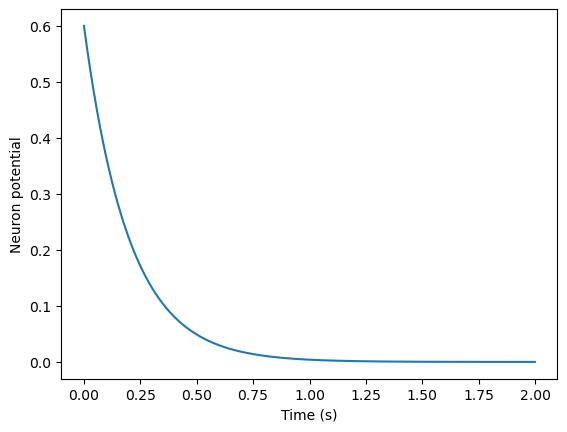

In [36]:
import matplotlib.pyplot as plt

plt.figure() # Create a new figure
plt.plot(times, v_history) # Plot the neuron's potential over time
plt.xlabel('Time (s)') # Label the x-axis
plt.ylabel('Neuron potential') # Label the y-axis
plt.show() # Display the plot

we can see that our neuron's potential (`neuron.v`) decays exponentially over time. Now, let's see what happens if we instead use a "square wave" input current. We'll define a `square_wave` function for this.

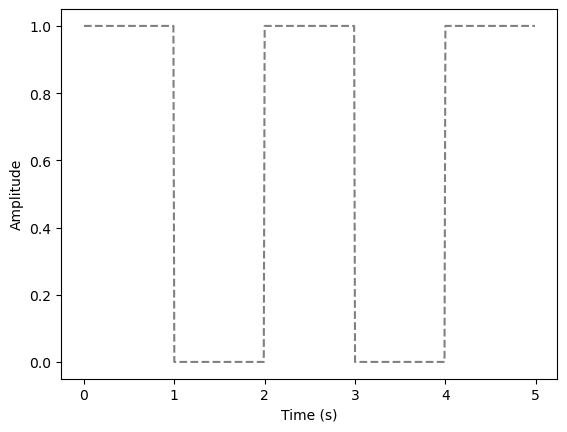

In [37]:
def square_wave_func(off_time_interval, on_time_interval=None): # Define a function that returns a square wave
    """
    off_time_interval: time interval for which the square wave is 0
    on_time_interval: time interval for which the square wave is 1
    """
    if on_time_interval is None:  # If on_time_interval is not provided, set it equal to off_time_interval
        on_time_interval = off_time_interval
    
    return lambda t: 1 if (t % (off_time_interval + on_time_interval)) < off_time_interval else 0 # Return a lambda function representing the square wave

square_wave = square_wave_func(1) # Create a square wave function with a period of 2 seconds

times = np.arange(0, 5, 0.01) # Create a range of time values
square_wave_values = [square_wave(t) for t in times] # Compute the square wave values

plt.figure() # Create a new figure
plt.plot(times, square_wave_values, color="grey", linestyle="--") # Plot the square wave
plt.xlabel('Time (s)') # Label the x-axis
plt.ylabel('Amplitude') # Label the y-axis
plt.show() # Display the plot

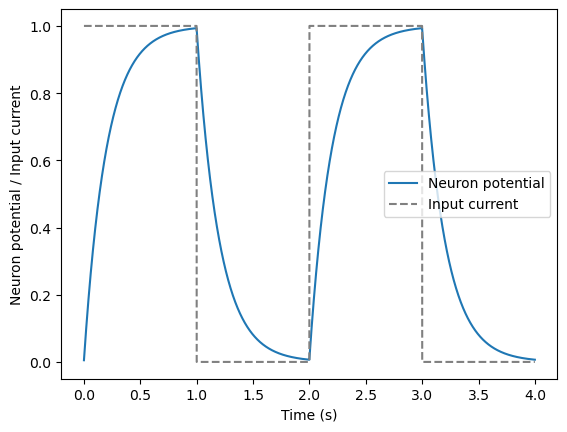

In [38]:
duration = 4 # Duration of the simulation: 6 seconds

neuron = FirstOrderLI() # Create a new instance with default parameters

v_history = []
I_history = []
times = np.arange(0, duration, T_step) # Create a range of time values

for t in times: # Loop over time
    I = square_wave(t) # Get the input current at time t
    neuron.step(I, T_step) # Advance one time step

    v_history.append(neuron.v) # Record the neuron's potential
    I_history.append(I)        # Record the input current

plt.figure() # Create a new figure
plt.plot(times, v_history) # Plot the neuron's potential over time
plt.plot(times, I_history, color="grey", linestyle="--") # Plot the input current over time
plt.xlabel('Time (s)') # Label the x-axis
plt.ylabel('Neuron potential / Input current') # Label the y-axis
plt.legend(['Neuron potential', 'Input current']) # Add a legend
plt.show() # Display the plot

## Simulation

Look at the code below and try different values for `tau_rc`, `T_step`, and `input_func`. Note how our simulation becomes inaccurate for large values of `T_step`. For example, *modify the code* so that:

- `tau_rc = 0.100`
- `T_step = 0.200`
- `input_func = "no-input"`

With this combination of parameters, we can overshoot `0` and oscillate instead of decaying. This shows that it's important to make $T_{step}$ small enough for accurate simulations.

```{editor} python
:packages: matplotlib,numpy
:run_on_load: true
:max_height: 500px

import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
v_init =   0.6   # Initial voltage for neuron
tau_rc =   0.500 # Time constant for neuron <-SLIDE(0.008 to 0.5 by 0.001)
T_step =   0.010 # Time step size <-SLIDE(0.001 to 0.2 by 0.001)
input_func = "square-wave"  # Input function <-SELECT("no-input", "square-wave")

duration = 4     # Total time for simulation

def no_input(t): return 0 # No input function
def square_wave_input(t): return 1 if (t % 2) < 1 else 0 # Square wave function

I_func = square_wave_input if input_func == "square-wave" else no_input

class FirstOrderLI: # First Order Leaky Integrate
    def __init__(self, tau_rc=0.2, v_init=0): # Default values for tau_rc and v_init
        self.tau_rc = tau_rc # Set instance variables
        self.v = v_init

    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc

neuron = FirstOrderLI(tau_rc = tau_rc, v_init = v_init) # create an instance of FirstOrderLI

# Time vector
times = np.arange(0, duration, T_step)
v_history = []
I_history = []

# Run the simulation
for t in times:
    I = I_func(t)
    neuron.step(I_func(t), T_step)
    I_history.append(I)
    v_history.append(neuron.v)

plt.figure() # Create a new figure
plt.plot(times, v_history) # Plot the neuron's potential over time
plt.plot(times, I_history, color="grey", linestyle="--") # Plot the input current over time
plt.xlabel('Time (s)') # Label the x-axis
plt.ylabel('Neuron potential / Input current') # Label the y-axis
plt.legend(['Neuron potential', 'Input current']) # Add a legend
plt.show() # Display the plot
```

In the next section, we'll introduce **firing**, to make our neurons proper LI**F** neurons.